In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import cv2
import numpy as np

# Custom Dataset Class
class SatelliteImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files) - 2

    def __getitem__(self, idx):
        img1 = cv2.imread(self.image_files[idx])
        img2 = cv2.imread(self.image_files[idx + 1])
        img3 = cv2.imread(self.image_files[idx + 2])

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return img1, img2, img3

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load dataset
image_folder = '/content/drive/MyDrive/images'  # Update with your image folder path
dataset = SatelliteImageDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Define Super SloMo Model (simplified version)
class SuperSloMo(nn.Module):
    def __init__(self):
        super(SuperSloMo, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, frame1, frame2):
        x = torch.cat((frame1, frame2), dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        interpolated_frame = self.conv4(x)
        return interpolated_frame

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SuperSloMo().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (frame_t1, frame_t, frame_t2) in enumerate(dataloader):
        frame_t1, frame_t, frame_t2 = frame_t1.to(device), frame_t.to(device), frame_t2.to(device)

        optimizer.zero_grad()

        interpolated_frame = model(frame_t1, frame_t2)

        loss = criterion(interpolated_frame, frame_t)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("Training complete!")

# Save the trained model
model_path = 'super_slo_mo.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/50], Loss: 0.0781
Epoch [2/50], Loss: 0.0621
Epoch [3/50], Loss: 0.0617
Epoch [4/50], Loss: 0.0614
Epoch [5/50], Loss: 0.0611
Epoch [6/50], Loss: 0.0608
Epoch [7/50], Loss: 0.0606
Epoch [8/50], Loss: 0.0605
Epoch [9/50], Loss: 0.0603
Epoch [10/50], Loss: 0.0601
Epoch [11/50], Loss: 0.0601
Epoch [12/50], Loss: 0.0599
Epoch [13/50], Loss: 0.0597
Epoch [14/50], Loss: 0.0597
Epoch [15/50], Loss: 0.0595
Epoch [16/50], Loss: 0.0593
Epoch [17/50], Loss: 0.0594
Epoch [18/50], Loss: 0.0593
Epoch [19/50], Loss: 0.0591
Epoch [20/50], Loss: 0.0591
Epoch [21/50], Loss: 0.0589
Epoch [22/50], Loss: 0.0589
Epoch [23/50], Loss: 0.0588
Epoch [24/50], Loss: 0.0587
Epoch [25/50], Loss: 0.0586
Epoch [26/50], Loss: 0.0586
Epoch [27/50], Loss: 0.0585
Epoch [28/50], Loss: 0.0585
Epoch [29/50], Loss: 0.0584
Epoch [30/50], Loss: 0.0583
Epoch [31/50], Loss: 0.0583
Epoch [32/50], Loss: 0.0582
Epoch [33/50], Loss: 0.0582
Epoch [34/50], Loss: 0.0581
Epoch [35/50], Loss: 0.0581
Epoch [36/50], Loss: 0.0580
E

In [ ]:
pip install torch torchvision opencv-python numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-e9bc28b9a35f>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


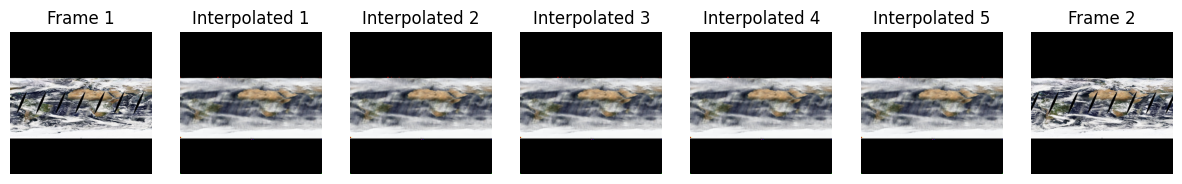

In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Define Super SloMo Model (as defined earlier)
class SuperSloMo(nn.Module):
    def __init__(self):
        super(SuperSloMo, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, frame1, frame2):
        x = torch.cat((frame1, frame2), dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        interpolated_frame = self.conv4(x)
        return interpolated_frame

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SuperSloMo().to(device)
model_path = 'super_slo_mo.pth'  # Path to the saved model
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Function to interpolate between frames
def interpolate_frames(model, frame1, frame2, num_interpolated_frames=1):
    """Interpolate frames between two input frames using the trained model."""
    interpolated_frames = []

    frame1 = transform(frame1).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension
    frame2 = transform(frame2).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(num_interpolated_frames):
            interpolated_frame = model(frame1, frame2)
            interpolated_frames.append(interpolated_frame.squeeze(0).cpu().numpy().transpose(1, 2, 0))  # Convert back to numpy

    return interpolated_frames

# Load the images
image_folder = '/content/drive/MyDrive/images'  # Update with your image folder path
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Example of generating interpolated frames between the first two images
frame1 = cv2.imread(image_files[0])
frame2 = cv2.imread(image_files[1])

# Generate interpolated frames
interpolated_frames = interpolate_frames(model, frame1, frame2, num_interpolated_frames=5)

# Display the original and interpolated frames
plt.figure(figsize=(15, 5))

# Display the first original frame
plt.subplot(1, len(interpolated_frames) + 2, 1)
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title('Frame 1')
plt.axis('off')

# Display the interpolated frames
for i, interpolated_frame in enumerate(interpolated_frames):
    plt.subplot(1, len(interpolated_frames) + 2, i + 2)
    plt.imshow(cv2.cvtColor((interpolated_frame * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f'Interpolated {i+1}')
    plt.axis('off')

# Display the second original frame
plt.subplot(1, len(interpolated_frames) + 2, len(interpolated_frames) + 2)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title('Frame 2')
plt.axis('off')

plt.show()


WITH RESIZING

In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Define Super SloMo Model (same as used during training)
class SuperSloMo(nn.Module):
    def __init__(self):
        super(SuperSloMo, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, frame1, frame2):
        x = torch.cat((frame1, frame2), dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        interpolated_frame = self.conv4(x)
        return interpolated_frame

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SuperSloMo().to(device)
model_path = 'super_slo_mo.pth'  # Path to the saved model
model.load_state_dict(torch.load(model_path))
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Function to interpolate frames
def interpolate_frames(frame1, frame2, num_interpolated_frames):
    frame1 = transform(frame1).unsqueeze(0).to(device)
    frame2 = transform(frame2).unsqueeze(0).to(device)
    interpolated_frames = []

    # Interpolating frames between frame1 and frame2
    for _ in range(num_interpolated_frames):
        with torch.no_grad():
            interpolated_frame = model(frame1, frame2)
            interpolated_frame_np = interpolated_frame.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            interpolated_frame_np = (interpolated_frame_np * 255).astype(np.uint8)
            interpolated_frames.append(interpolated_frame_np)
            frame1 = interpolated_frame  # Use the last interpolated frame as the next frame1

    return interpolated_frames

# User input: number of interpolated frames to generate between each pair
num_interpolated_frames = int(input("Enter the number of interpolated frames to generate between each pair of frames: "))

# Path to images
image_folder = '/content/drive/MyDrive/images'  # Update with your image folder path
output_video_path = 'output_video.mp4'  # Path to save the output video

image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Video settings
frame_rate = 30
frame_size = (256, 256)  # Resize frames to this size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, frame_size)

# Read and process frames
for i in range(len(image_files) - 1):
    frame1 = cv2.imread(image_files[i])
    frame2 = cv2.imread(image_files[i + 1])

    # Add original frame1 to video
    video_writer.write(cv2.resize(frame1, frame_size))

    # Generate interpolated frames and add them to the video
    interpolated_frames = interpolate_frames(frame1, frame2, num_interpolated_frames)
    for frame in interpolated_frames:
        video_writer.write(cv2.resize(frame, frame_size))

    # Add original frame2 to video
    video_writer.write(cv2.resize(frame2, frame_size))

# Release the video writer
video_writer.release()
print(f"Video saved to {output_video_path}")


<ipython-input-3-cf951168ea4a>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Enter the number of interpolated frames to generate between each pair of frames: 10
Video saved to output_video.mp4


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Define Super SloMo Model (same as used during training)
class SuperSloMo(nn.Module):
    def __init__(self):
        super(SuperSloMo, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, frame1, frame2):
        x = torch.cat((frame1, frame2), dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        interpolated_frame = self.conv4(x)
        return interpolated_frame

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SuperSloMo().to(device)
model_path = 'super_slo_mo.pth'  # Path to the saved model
model.load_state_dict(torch.load(model_path))
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((720, 1280)),  # Higher resolution
    transforms.ToTensor(),
])

# Function to interpolate frames
def interpolate_frames(frame1, frame2, num_interpolated_frames):
    frame1 = transform(frame1).unsqueeze(0).to(device)
    frame2 = transform(frame2).unsqueeze(0).to(device)
    interpolated_frames = []

    # Interpolating frames between frame1 and frame2
    for _ in range(num_interpolated_frames):
        with torch.no_grad():
            interpolated_frame = model(frame1, frame2)
            interpolated_frame_np = interpolated_frame.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            interpolated_frame_np = np.clip(interpolated_frame_np * 255.0, 0, 255).astype(np.uint8)  # Normalize and convert to uint8
            interpolated_frames.append(interpolated_frame_np)
            frame1 = interpolated_frame  # Use the last interpolated frame as the next frame1

    return interpolated_frames

# User input: number of interpolated frames to generate between each pair
num_interpolated_frames = int(input("Enter the number of interpolated frames to generate between each pair of frames: "))

# Path to images
image_folder = '/content/drive/MyDrive/images'  # Update with your image folder path
output_video_path = 'output_video.mp4'  # Path to save the output video

image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Video settings
frame_rate = 30
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (1280, 720))  # Higher resolution

# Read and process frames
for i in range(len(image_files) - 1):
    frame1 = cv2.imread(image_files[i])
    frame2 = cv2.imread(image_files[i + 1])

    # Convert BGR to RGB as OpenCV loads images in BGR
    frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

    # Add original frame1 to video
    video_writer.write(cv2.resize(frame1, (1280, 720)))

    # Generate interpolated frames and add them to the video
    interpolated_frames = interpolate_frames(frame1_rgb, frame2_rgb, num_interpolated_frames)
    for frame in interpolated_frames:
        video_writer.write(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR), (1280, 720)))

    # Add original frame2 to video
    video_writer.write(cv2.resize(frame2, (1280, 720)))

# Release the video writer
video_writer.release()
print(f"Video saved to {output_video_path}")


<ipython-input-3-bfe8a552285a>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

1280 x 720 quality


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Define Super SloMo Model (same as used during training)
class SuperSloMo(nn.Module):
    def __init__(self):
        super(SuperSloMo, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, frame1, frame2):
        x = torch.cat((frame1, frame2), dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        interpolated_frame = self.conv4(x)
        return interpolated_frame

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SuperSloMo().to(device)
model_path = 'super_slo_mo.pth'  # Path to the saved model
model.load_state_dict(torch.load(model_path))
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((720, 1280)),  # Higher resolution
    transforms.ToTensor(),
])

# Function to interpolate frames
def interpolate_frames(frame1, frame2, num_interpolated_frames):
    frame1 = transform(frame1).unsqueeze(0).to(device)
    frame2 = transform(frame2).unsqueeze(0).to(device)
    interpolated_frames = []

    # Interpolating frames between frame1 and frame2
    for _ in range(num_interpolated_frames):
        with torch.no_grad():
            interpolated_frame = model(frame1, frame2)
            interpolated_frame_np = interpolated_frame.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            interpolated_frame_np = np.clip(interpolated_frame_np * 255.0, 0, 255).astype(np.uint8)  # Normalize and convert to uint8
            interpolated_frames.append(interpolated_frame_np)
            frame1 = interpolated_frame  # Use the last interpolated frame as the next frame1

    return interpolated_frames

# User input: number of interpolated frames to generate between each pair
num_interpolated_frames = int(input("Enter the number of interpolated frames to generate between each pair of frames: "))

# Path to images
image_folder = '/content/drive/MyDrive/images'  # Update with your image folder path
output_video_path = 'output_video.mp4'  # Path to save the output video

image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Video settings
frame_rate = 30
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (1280, 720))  # Higher resolution

# Read and process frames
for i in range(len(image_files) - 1):
    frame1 = cv2.imread(image_files[i])
    frame2 = cv2.imread(image_files[i + 1])

    # Convert BGR to RGB as OpenCV loads images in BGR
    frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

    # Add original frame1 to video
    video_writer.write(cv2.resize(frame1, (1280, 720)))

    # Generate interpolated frames and add them to the video
    interpolated_frames = interpolate_frames(frame1_rgb, frame2_rgb, num_interpolated_frames)
    for frame in interpolated_frames:
        video_writer.write(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR), (1280, 720)))

    # Add original frame2 to video
    video_writer.write(cv2.resize(frame2, (1280, 720)))

# Release the video writer
video_writer.release()
print(f"Video saved to {output_video_path}")


Original quality

In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Define Super SloMo Model (same as used during training)
class SuperSloMo(nn.Module):
    def __init__(self):
        super(SuperSloMo, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, frame1, frame2):
        x = torch.cat((frame1, frame2), dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        interpolated_frame = self.conv4(x)
        return interpolated_frame

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SuperSloMo().to(device)
model_path = 'super_slo_mo.pth'  # Path to the saved model
model.load_state_dict(torch.load(model_path))
model.eval()

# Define transformations (maintain original resolution)
def preprocess(frame):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])
    return transform(frame).unsqueeze(0).to(device)

# Function to interpolate frames
def interpolate_frames(frame1, frame2, num_interpolated_frames):
    frame1 = preprocess(frame1)
    frame2 = preprocess(frame2)
    interpolated_frames = []

    # Interpolating frames between frame1 and frame2
    for _ in range(num_interpolated_frames):
        with torch.no_grad():
            interpolated_frame = model(frame1, frame2)
            interpolated_frame_np = interpolated_frame.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            interpolated_frame_np = np.clip(interpolated_frame_np * 255.0, 0, 255).astype(np.uint8)  # Normalize and convert to uint8
            interpolated_frames.append(interpolated_frame_np)
            frame1 = interpolated_frame  # Use the last interpolated frame as the next frame1

    return interpolated_frames

# User input: number of interpolated frames to generate between each pair
num_interpolated_frames = int(input("Enter the number of interpolated frames to generate between each pair of frames: "))

# Path to images
image_folder = '/content/drive/MyDrive/images'  # Update with your image folder path
output_video_path = 'output_video_high_quality.mp4'  # Path to save the output video

image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Extract the resolution from the first image
first_frame = cv2.imread(image_files[0])
frame_height, frame_width, _ = first_frame.shape

# Video settings (use original resolution)
frame_rate = 30
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (frame_width, frame_height))

# Read and process frames
for i in range(len(image_files) - 1):
    frame1 = cv2.imread(image_files[i])
    frame2 = cv2.imread(image_files[i + 1])

    # Convert BGR to RGB as OpenCV loads images in BGR
    frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

    # Add original frame1 to video
    video_writer.write(cv2.resize(frame1, (frame_width, frame_height)))

    # Generate interpolated frames and add them to the video
    interpolated_frames = interpolate_frames(frame1_rgb, frame2_rgb, num_interpolated_frames)
    for frame in interpolated_frames:
        video_writer.write(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR), (frame_width, frame_height)))

    # Add original frame2 to video
    video_writer.write(cv2.resize(frame2, (frame_width, frame_height)))

# Release the video writer
video_writer.release()
print(f"High-quality video saved to {output_video_path}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the Generator Network (Spatio-Temporal + Convolutional Layers)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Conv layers to extract features from both frames (Spatio-Temporal)
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

        # Temporal Layer: Simple LSTM (to capture temporal motion)
        self.lstm = nn.LSTM(input_size=256*256, hidden_size=512, num_layers=2, batch_first=True)

        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, frame1, frame2):
        # Concatenate frames along the channel dimension
        x = torch.cat((frame1, frame2), dim=1)

        # Apply convolutional layers to extract features
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        # Flatten for temporal processing
        x = x.view(x.size(0), -1)  # Flatten the spatial dimensions
        x, _ = self.lstm(x.unsqueeze(1))  # Apply LSTM for temporal motion

        # Generate interpolated frame
        interpolated_frame = self.conv4(x.view(x.size(0), 64, 256, 256))  # Reshape back to image dimensions
        return interpolated_frame

# Define the Discriminator Network (to distinguish between real and generated frames)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(256 * 32 * 32, 1)  # Adjust based on input size
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc(x)
        return self.sigmoid(x)

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss functions and optimizers
criterion_GAN = nn.BCELoss()
criterion_content = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Function to interpolate frames using GAN-based generator
def interpolate_frames(generator, discriminator, frame1, frame2, num_interpolated_frames=1):
    """Generate interpolated frames between two input frames using GAN."""
    interpolated_frames = []

    frame1 = transform(frame1).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension
    frame2 = transform(frame2).unsqueeze(0).to(device)

    # Training loop for each interpolation step
    for _ in range(num_interpolated_frames):
        optimizer_G.zero_grad()

        # Generate interpolated frame
        interpolated_frame = generator(frame1, frame2)

        # Train Discriminator: Real or Fake?
        real_label = torch.ones(1, 1).to(device)
        fake_label = torch.zeros(1, 1).to(device)

        # Calculate the loss for the Discriminator
        real_loss = criterion_GAN(discriminator(frame2), real_label)  # Real frame (second frame)
        fake_loss = criterion_GAN(discriminator(interpolated_frame), fake_label)  # Fake (generated frame)
        loss_D = (real_loss + fake_loss) / 2

        # Backpropagate Discriminator loss
        loss_D.backward()
        optimizer_D.step()

        # Generator loss
        loss_GAN = criterion_GAN(discriminator(interpolated_frame), real_label)
        loss_content = criterion_content(interpolated_frame, frame2)  # Content loss to preserve details
        loss_G = loss_GAN + loss_content

        # Backpropagate Generator loss
        loss_G.backward()
        optimizer_G.step()

        # Append the interpolated frame to the list
        interpolated_frames.append(interpolated_frame.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))

    return interpolated_frames

# Load the images (update with your path)
image_folder = '/content/drive/MyDrive/images'  # Update with your image folder path
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Example of generating interpolated frames between the first two images
frame1 = cv2.imread(image_files[0])
frame2 = cv2.imread(image_files[1])

# Generate interpolated frames
interpolated_frames = interpolate_frames(generator, discriminator, frame1, frame2, num_interpolated_frames=5)

# Display the original and interpolated frames
plt.figure(figsize=(15, 5))

# Display the first original frame
plt.subplot(1, len(interpolated_frames) + 2, 1)
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title('Frame 1')
plt.axis('off')

# Display the interpolated frames
for i, interpolated_frame in enumerate(interpolated_frames):
    plt.subplot(1, len(interpolated_frames) + 2, i + 2)
    plt.imshow(cv2.cvtColor((interpolated_frame * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f'Interpolated {i+1}')
    plt.axis('off')

# Display the second original frame
plt.subplot(1, len(interpolated_frames) + 2, len(interpolated_frames) + 2)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title('Frame 2')
plt.axis('off')

plt.show()


Processing video


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the video
video_path = '/content/drive/MyDrive/output_video_high_quality.mp4'  # Update with your video path
cap = cv2.VideoCapture(video_path)

# Check if the video was loaded successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Initialize variables to store metrics
cloud_cover_percentages = []
water_body_percentages = []
vegetation_cover_percentages = []
urban_area_percentages = []

# Function to calculate metrics for each frame
def analyze_frame(frame):
    """Analyze a frame to calculate cloud cover, water bodies, vegetation, and urban areas."""
    # Convert frame to HSV for easier color segmentation
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # 1. Cloud Cover Detection (White and light gray colors in RGB or HSV)
    lower_cloud = np.array([0, 0, 200])  # Light gray/white lower bound
    upper_cloud = np.array([180, 50, 255])  # Light gray/white upper bound
    cloud_mask = cv2.inRange(hsv_frame, lower_cloud, upper_cloud)
    cloud_cover = np.sum(cloud_mask > 0) / cloud_mask.size * 100

    # 2. Water Body Detection (Dark blue colors in HSV)
    lower_water = np.array([90, 50, 20])  # Dark blue lower bound
    upper_water = np.array([130, 255, 255])  # Dark blue upper bound
    water_mask = cv2.inRange(hsv_frame, lower_water, upper_water)
    water_body_cover = np.sum(water_mask > 0) / water_mask.size * 100

    # 3. Vegetation Detection (Green colors in HSV)
    lower_vegetation = np.array([35, 40, 20])  # Green lower bound
    upper_vegetation = np.array([85, 255, 255])  # Green upper bound
    vegetation_mask = cv2.inRange(hsv_frame, lower_vegetation, upper_vegetation)
    vegetation_cover = np.sum(vegetation_mask > 0) / vegetation_mask.size * 100

    # 4. Urban Area Detection (Grayish colors in HSV)
    lower_urban = np.array([0, 0, 50])  # Gray lower bound
    upper_urban = np.array([180, 50, 200])  # Gray upper bound
    urban_mask = cv2.inRange(hsv_frame, lower_urban, upper_urban)
    urban_area_cover = np.sum(urban_mask > 0) / urban_mask.size * 100

    return cloud_cover, water_body_cover, vegetation_cover, urban_area_cover

# Process the video frame by frame
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Analyze the current frame
    cloud_cover, water_body_cover, vegetation_cover, urban_area_cover = analyze_frame(frame)

    # Store the results
    cloud_cover_percentages.append(cloud_cover)
    water_body_percentages.append(water_body_cover)
    vegetation_cover_percentages.append(vegetation_cover)
    urban_area_percentages.append(urban_area_cover)

# Release the video capture object
cap.release()

# Plot the metrics
plt.figure(figsize=(12, 8))

# Cloud Cover Plot
plt.subplot(2, 2, 1)
plt.plot(cloud_cover_percentages, color='blue')
plt.title('Cloud Cover Percentage Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Cloud Cover (%)')

# Water Body Plot
plt.subplot(2, 2, 2)
plt.plot(water_body_percentages, color='cyan')
plt.title('Water Body Percentage Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Water Body Cover (%)')

# Vegetation Cover Plot
plt.subplot(2, 2, 3)
plt.plot(vegetation_cover_percentages, color='green')
plt.title('Vegetation Cover Percentage Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Vegetation Cover (%)')

# Urban Area Plot
plt.subplot(2, 2, 4)
plt.plot(urban_area_percentages, color='gray')
plt.title('Urban Area Percentage Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Urban Area Cover (%)')

plt.tight_layout()
plt.show()


GAN AND Spatio temporal model approach


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the Generator Network (Spatio-Temporal + Convolutional Layers)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Conv layers to extract features from both frames (Spatio-Temporal)
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

        # Temporal Layer: Simple LSTM (to capture temporal motion)
        self.lstm = nn.LSTM(input_size=256*256, hidden_size=512, num_layers=2, batch_first=True)

        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, frame1, frame2):
        # Concatenate frames along the channel dimension
        x = torch.cat((frame1, frame2), dim=1)

        # Apply convolutional layers to extract features
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        # Flatten for temporal processing
        x = x.view(x.size(0), -1)  # Flatten the spatial dimensions
        x, _ = self.lstm(x.unsqueeze(1))  # Apply LSTM for temporal motion

        # Generate interpolated frame
        interpolated_frame = self.conv4(x.view(x.size(0), 64, 256, 256))  # Reshape back to image dimensions
        return interpolated_frame

# Define the Discriminator Network (to distinguish between real and generated frames)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(256 * 32 * 32, 1)  # Adjust based on input size
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc(x)
        return self.sigmoid(x)

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss functions and optimizers
criterion_GAN = nn.BCELoss()
criterion_content = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Function to interpolate frames using GAN-based generator
def interpolate_frames(generator, discriminator, frame1, frame2, num_interpolated_frames=1):
    """Generate interpolated frames between two input frames using GAN."""
    interpolated_frames = []

    frame1 = transform(frame1).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension
    frame2 = transform(frame2).unsqueeze(0).to(device)

    # Training loop for each interpolation step
    for _ in range(num_interpolated_frames):
        optimizer_G.zero_grad()

        # Generate interpolated frame
        interpolated_frame = generator(frame1, frame2)

        # Train Discriminator: Real or Fake?
        real_label = torch.ones(1, 1).to(device)
        fake_label = torch.zeros(1, 1).to(device)

        # Calculate the loss for the Discriminator
        real_loss = criterion_GAN(discriminator(frame2), real_label)  # Real frame (second frame)
        fake_loss = criterion_GAN(discriminator(interpolated_frame), fake_label)  # Fake (generated frame)
        loss_D = (real_loss + fake_loss) / 2

        # Backpropagate Discriminator loss
        loss_D.backward()
        optimizer_D.step()

        # Generator loss
        loss_GAN = criterion_GAN(discriminator(interpolated_frame), real_label)
        loss_content = criterion_content(interpolated_frame, frame2)  # Content loss to preserve details
        loss_G = loss_GAN + loss_content

        # Backpropagate Generator loss
        loss_G.backward()
        optimizer_G.step()

        # Append the interpolated frame to the list
        interpolated_frames.append(interpolated_frame.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))

    return interpolated_frames

# Load the images (update with your path)
image_folder = '/content/drive/MyDrive/images'  # Update with your image folder path
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Example of generating interpolated frames between the first two images
frame1 = cv2.imread(image_files[0])
frame2 = cv2.imread(image_files[1])

# Generate interpolated frames
interpolated_frames = interpolate_frames(generator, discriminator, frame1, frame2, num_interpolated_frames=5)

# Display the original and interpolated frames
plt.figure(figsize=(15, 5))

# Display the first original frame
plt.subplot(1, len(interpolated_frames) + 2, 1)
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title('Frame 1')
plt.axis('off')

# Display the interpolated frames
for i, interpolated_frame in enumerate(interpolated_frames):
    plt.subplot(1, len(interpolated_frames) + 2, i + 2)
    plt.imshow(cv2.cvtColor((interpolated_frame * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f'Interpolated {i+1}')
    plt.axis('off')

# Display the second original frame
plt.subplot(1, len(interpolated_frames) + 2, len(interpolated_frames) + 2)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title('Frame 2')
plt.axis('off')

plt.show()
